In [2]:
%matplotlib notebook


from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import os
import numpy as np
import pandas as pd
import glob
import json
import scipy as sp
import pdb
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits

from myutils import *

In [3]:
from lsst.obs.lsst import LsstCam
camera = LsstCam.getCamera()
det_names = {i: det.getName() for i, det in enumerate(camera)}
det_ptypes = {i: det.getPhysicalType() for i, det in enumerate(camera)}
det_nums = {det.getName():i for i, det in enumerate(camera)}

# Get Single Raft QE data

In [4]:
goodruns = get_goodruns(loc='slac',useold=False)
rtmids = get_rtmids()
baytype = get_rtmtype()

## revise missing/bad data...

1. R30_S00 has no data, see /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-012/11063/qe_raft_analysis/v0/85826/S00 problem is the one dead channel has nan's - fixed in code
2. R32_S11 has values at 1000 or so, and the Run 11063 only has a small number of wavelengths too.  Is there a better run to use? Use BNL Run 7678, with file in: /nfs/farm/g/lsst/u1/mirror/BNL-prod/prod/LCA-11021_RTM/LCA-11021_RTM-015/7678/qe_raft_analysis/v0/50602/S00/E2V-CCD250-293_QE.fits.  See: https://confluence.slac.stanford.edu/display/LSSTCAM/Useful+TS8+runs for the runs that exist from BNL data

In [5]:
print(goodruns)
print(rtmids)
print(baytype)


# modify goodrun for RTM-015 to use the BNL D run 7678
goodruns['RTM-015'] = '7678'

# modify goodruns for these, to use BNL D runs with more wavelengths, since I&T good run has only 6 or 7 points
goodruns['RTM-020'] = '9442'
goodruns['RTM-017'] = '8872'
goodruns['RTM-025'] = '10238'

{'RTM-004': '11977', 'RTM-005': '11852', 'RTM-006': '11746', 'RTM-007': '11903', 'RTM-008': '11952', 'RTM-009': '11415', 'RTM-010': '12139', 'RTM-011': '10861', 'RTM-012': '11063', 'RTM-013': '10982', 'RTM-014': '10928', 'RTM-015': '12002', 'RTM-016': '12027', 'RTM-017': '11166', 'RTM-018': '12120', 'RTM-019': '11808', 'RTM-020': '10669', 'RTM-021': '12086', 'RTM-022': '11671', 'RTM-023': '10517', 'RTM-024': '11351', 'RTM-025': '10722', 'CRTM-0002': '6611D', 'CRTM-0003': '10909', 'CRTM-0004': '11128', 'CRTM-0005': '11260'}
{'R00': 'CRTM-0002', 'R40': 'CRTM-0003', 'R04': 'CRTM-0004', 'R44': 'CRTM-0005', 'R10': 'RTM-023', 'R20': 'RTM-014', 'R30': 'RTM-012', 'R01': 'RTM-011', 'R11': 'RTM-020', 'R21': 'RTM-025', 'R31': 'RTM-007', 'R41': 'RTM-021', 'R02': 'RTM-013', 'R12': 'RTM-009', 'R22': 'RTM-024', 'R32': 'RTM-015', 'R42': 'RTM-018', 'R03': 'RTM-017', 'R13': 'RTM-019', 'R23': 'RTM-005', 'R33': 'RTM-010', 'R43': 'RTM-022', 'R14': 'RTM-006', 'R24': 'RTM-016', 'R34': 'RTM-008'}
{'R01': 'itl

In [6]:
def getQEFile(raft,slot,run):
    
    disk = 'fs1'
    raftdir = '/gpfs/slac/lsst/%s/g/data/jobHarness/jh_archive/LCA-11021_RTM/' % (disk)
    qedir = 'LCA-11021_%s/%s/qe_raft_analysis/v0/*/%s/' % (raft,run,slot)
    files = glob.glob(raftdir+qedir+'*.fits')
    
    if len(files)==0:
        disk = 'fs3'
        raftdir = '/gpfs/slac/lsst/%s/g/data/jobHarness/jh_archive/LCA-11021_RTM/' % (disk)
        files = glob.glob(raftdir+qedir+'*.fits')
        
        if len(files)==0:
            raftdir = '/nfs/farm/g/lsst/u1/mirror/BNL-prod/prod/LCA-11021_RTM/'
            files = glob.glob(raftdir+qedir+'*.fits')
        
    return files
    

def getQE(raft,bay,run):
    
    wll = []
    qel = []
    slotl = []
    bayl = []
    rtypel = []
    bayslotl = []
    idetl = []
    
    slots = get_slots()

    for slot in slots:
        files = getQEFile(raft,slot,run)
        if len(files)==1:
            
            hdu = fits.open(files[0]) 
            data = hdu[1].data
            
            nlam = len(data)
            print(bay,slot,nlam)
            wl_arr = np.zeros((nlam))
            qe_arr = np.zeros((nlam))
            for alam in range(nlam):
                wl = data[alam][0]
                qeval = data[alam][-1]  # has 16 amp values, then average last
                
                if np.isnan(qeval):
                    # get the 16 values and take the mean filtering the nans
                    qarr = data[alam][1:16+1]
                    qeval = np.nanmean(qarr)
                
                wl_arr[alam] = wl
                qe_arr[alam] = qeval
        
            wll.append(wl_arr)
            qel.append(qe_arr)
            slotl.append(slot)
            bayl.append(bay)
            rtypel.append(baytype[bay])
            bayslot = bay+"_"+slot
            bayslotl.append(bayslot)
            idetl.append(det_nums[bayslot])
        
    dd = {}
    dd['idet'] = idetl
    dd['bayslot'] = bayslotl
    dd['wl'] = wll
    dd['qe'] = qel
    dd['slot'] = slotl
    dd['bay'] = bayl
    dd['type'] = rtypel
    
    df = pd.DataFrame(dd)
    return df

In [7]:
df23 = getQE(raft='RTM-005',bay='R23',run='11852')
df30 = getQE(raft='RTM-012',bay='R30',run='11063')
df32 = getQE(raft='RTM-015',bay='R32',run='7678')

R23 S00 36
R23 S01 36
R23 S02 36
R23 S10 36
R23 S11 36
R23 S12 36
R23 S20 36
R23 S21 36
R23 S22 36
R30 S00 36
R30 S01 36
R30 S02 36
R30 S10 36
R30 S11 36
R30 S12 36
R30 S20 36
R30 S21 36
R30 S22 36
R32 S00 30
R32 S01 30
R32 S02 30
R32 S10 30
R32 S11 30
R32 S12 30
R32 S20 30
R32 S21 30
R32 S22 30


<IPython.core.display.Javascript object>


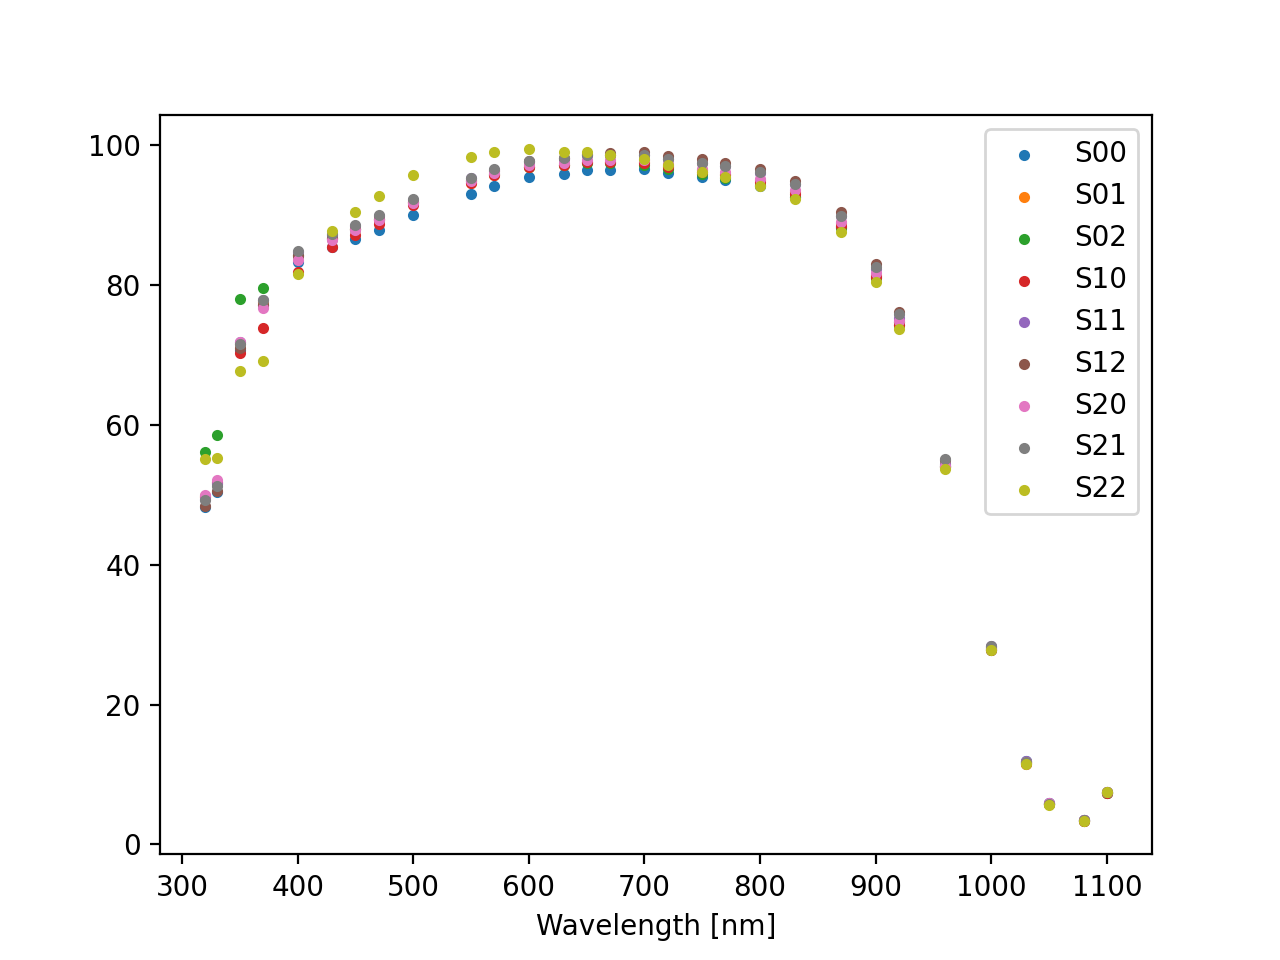

Text(0.5, 0, 'Wavelength [nm]')

In [8]:
df = df32
f,ax = plt.subplots(1,1)
slots = get_slots()
for i,slot in enumerate(slots):
    dff = df[(df.slot==slot)]
    h = ax.scatter(dff['wl'][i],dff['qe'][i],marker='.',label=slot)
    
ax.legend()
ax.set_xlabel('Wavelength [nm]')

## get all bays

In [9]:
dfs = []
for bay in baytype.keys():
    
    print(bay)
    raft = rtmids[bay]
    run = goodruns[raft]
    
    dfs.append(getQE(raft,bay,run))
    
dfall = pd.concat(dfs)
dfall.set_index('idet')
    

R01
R01 S00 36
R01 S01 36
R01 S02 36
R01 S10 36
R01 S11 36
R01 S12 36
R01 S20 36
R01 S21 36
R01 S22 36
R02
R02 S00 36
R02 S01 36
R02 S02 36
R02 S10 36
R02 S11 36
R02 S12 36
R02 S20 36
R02 S21 36
R02 S22 36
R03
R03 S00 30
R03 S01 30
R03 S02 30
R03 S10 30
R03 S11 30
R03 S12 30
R03 S20 30
R03 S21 30
R03 S22 30
R10
R10 S00 36
R10 S01 36
R10 S02 36
R10 S10 36
R10 S11 36
R10 S12 36
R10 S20 36
R10 S21 36
R10 S22 36
R11
R11 S00 30
R11 S01 30
R11 S02 30
R11 S10 30
R11 S11 30
R11 S12 30
R11 S20 30
R11 S21 30
R11 S22 30
R12
R12 S00 36
R12 S01 36
R12 S02 36
R12 S10 36
R12 S11 36
R12 S12 36
R12 S20 36
R12 S21 36
R12 S22 36
R13
R13 S00 36
R13 S01 36
R13 S02 36
R13 S10 36
R13 S11 36
R13 S12 36
R13 S20 36
R13 S21 36
R13 S22 36
R14
R14 S00 36
R14 S01 36
R14 S02 36
R14 S10 36
R14 S11 36
R14 S12 36
R14 S20 36
R14 S21 36
R14 S22 36
R20
R20 S00 36
R20 S01 36
R20 S02 36
R20 S10 36
R20 S11 36
R20 S12 36
R20 S20 36
R20 S21 36
R20 S22 36
R21
R21 S00 30
R21 S01 30
R21 S02 30
R21 S10 30
R21 S11 30
R21 S12 30
R21

,bayslot,wl,qe,slot,bay,type
idet,,,,,,
0,R01_S00,"[319.9939880371094, 324.968994140625, 349.9819...","[48.62901306152344, 50.684478759765625, 61.073...",S00,R01,itl
1,R01_S01,"[319.9939880371094, 324.968994140625, 349.9819...","[43.776634216308594, 44.711612701416016, 51.11...",S01,R01,itl
2,R01_S02,"[319.9939880371094, 324.968994140625, 349.9819...","[49.37493896484375, 51.3961181640625, 61.52243...",S02,R01,itl
3,R01_S10,"[319.9939880371094, 324.968994140625, 349.9819...","[49.03248977661133, 51.226158142089844, 62.138...",S10,R01,itl
4,R01_S11,"[319.9939880371094, 324.968994140625, 349.9819...","[50.25616455078125, 52.671043395996094, 64.050...",S11,R01,itl
...,...,...,...,...,...,...
184,R43_S11,"[319.9939880371094, 324.968994140625, 349.9819...","[51.537864685058594, 53.83469009399414, 65.350...",S11,R43,itl
185,R43_S12,"[319.9939880371094, 324.968994140625, 349.9819...","[50.58000183105469, 52.9389533996582, 64.50895...",S12,R43,itl
186,R43_S20,"[319.9939880371094, 324.968994140625, 349.9819...","[64.72469329833984, 67.41368103027344, 74.7405...",S20,R43,itl


In [10]:
print(dfall)

    idet  bayslot                                                 wl  \
0      0  R01_S00  [319.9939880371094, 324.968994140625, 349.9819...   
1      1  R01_S01  [319.9939880371094, 324.968994140625, 349.9819...   
2      2  R01_S02  [319.9939880371094, 324.968994140625, 349.9819...   
3      3  R01_S10  [319.9939880371094, 324.968994140625, 349.9819...   
4      4  R01_S11  [319.9939880371094, 324.968994140625, 349.9819...   
..   ...      ...                                                ...   
4    184  R43_S11  [319.9939880371094, 324.968994140625, 349.9819...   
5    185  R43_S12  [319.9939880371094, 324.968994140625, 349.9819...   
6    186  R43_S20  [319.9939880371094, 324.968994140625, 349.9819...   
7    187  R43_S21  [319.9939880371094, 324.968994140625, 349.9819...   
8    188  R43_S22  [319.9939880371094, 324.968994140625, 349.9819...   

                                                   qe slot  bay type  
0   [48.62901306152344, 50.684478759765625, 61.073...  S00  R01 

In [11]:
dfall.to_parquet('qe_raft_values.parquet')

In [12]:
dfall['wl'].iloc[1]

array([ 319.99398804,  324.96899414,  349.98199463,  374.9750061 ,
        400.01901245,  424.96499634,  450.03500366,  475.00299072,
        500.01800537,  525.00201416,  550.0289917 ,  575.02301025,
        599.98199463,  619.99700928,  624.97900391,  650.01202393,
        675.00402832,  700.0300293 ,  725.01202393,  750.02197266,
        774.98699951,  799.97601318,  824.98797607,  850.02197266,
        869.96697998,  875.00201416,  899.99902344,  919.99902344,
        925.01202393,  949.96502686,  975.00201416,  999.97601318,
       1025.0279541 , 1050.01403809, 1075.00195312, 1099.98999023])

In [13]:
dfall['wl'].iloc[120]

array([ 319.99398804,  324.96899414,  349.98199463,  374.9750061 ,
        400.01901245,  424.96499634,  450.03500366,  475.00299072,
        500.01800537,  525.00201416,  550.0289917 ,  575.02301025,
        599.98199463,  619.99700928,  624.97900391,  650.01202393,
        675.00402832,  700.0300293 ,  725.01202393,  750.02197266,
        774.98699951,  799.97601318,  824.98797607,  850.02197266,
        869.96697998,  875.00201416,  899.99902344,  919.99902344,
        925.01202393,  949.96502686,  975.00201416,  999.97601318,
       1025.0279541 , 1050.01403809, 1075.00195312, 1099.98999023])

In [14]:
dfall['qe'].iloc[98]

array([41.54891586, 46.93406677, 72.69873047, 80.91736603, 87.19115448,
       87.42672729, 88.16522217, 90.09017944, 91.97477722, 93.89083862,
       95.47058868, 96.29959106, 97.94868469, 98.25874329, 98.40936279,
       98.92562103, 99.323349  , 98.86765289, 98.6132431 , 99.17599487,
       99.63536835, 98.97937012, 97.14147186, 95.25022125, 92.1771698 ,
       91.61647034, 84.04566956, 74.36165619, 72.15381622, 58.81570053,
       43.94190979, 26.55071259, 11.51881123,  4.07831335,  2.19336581,
        1.59908044])

In [15]:
dfall['qe'].iloc[120]

array([43.50377274, 49.06491852, 75.05995941, 81.77127838, 86.34671783,
       87.22075653, 88.15750122, 90.01041412, 91.88363647, 93.65494537,
       95.06105804, 96.53929138, 97.75047302, 97.90550232, 97.95581055,
       98.37851715, 98.65365601, 98.28410339, 97.79972076, 97.93373871,
       98.00972748, 97.16485596, 95.68367767, 93.47164154, 90.41028595,
       89.35675812, 82.61342621, 74.01183319, 71.18005371, 57.85630035,
       42.71305084, 26.20766068, 11.37143517,  3.91274095,  2.09389186,
        1.58918405])

In [16]:
from matplotlib.legend_handler import HandlerPolyCollection

<IPython.core.display.Javascript object>


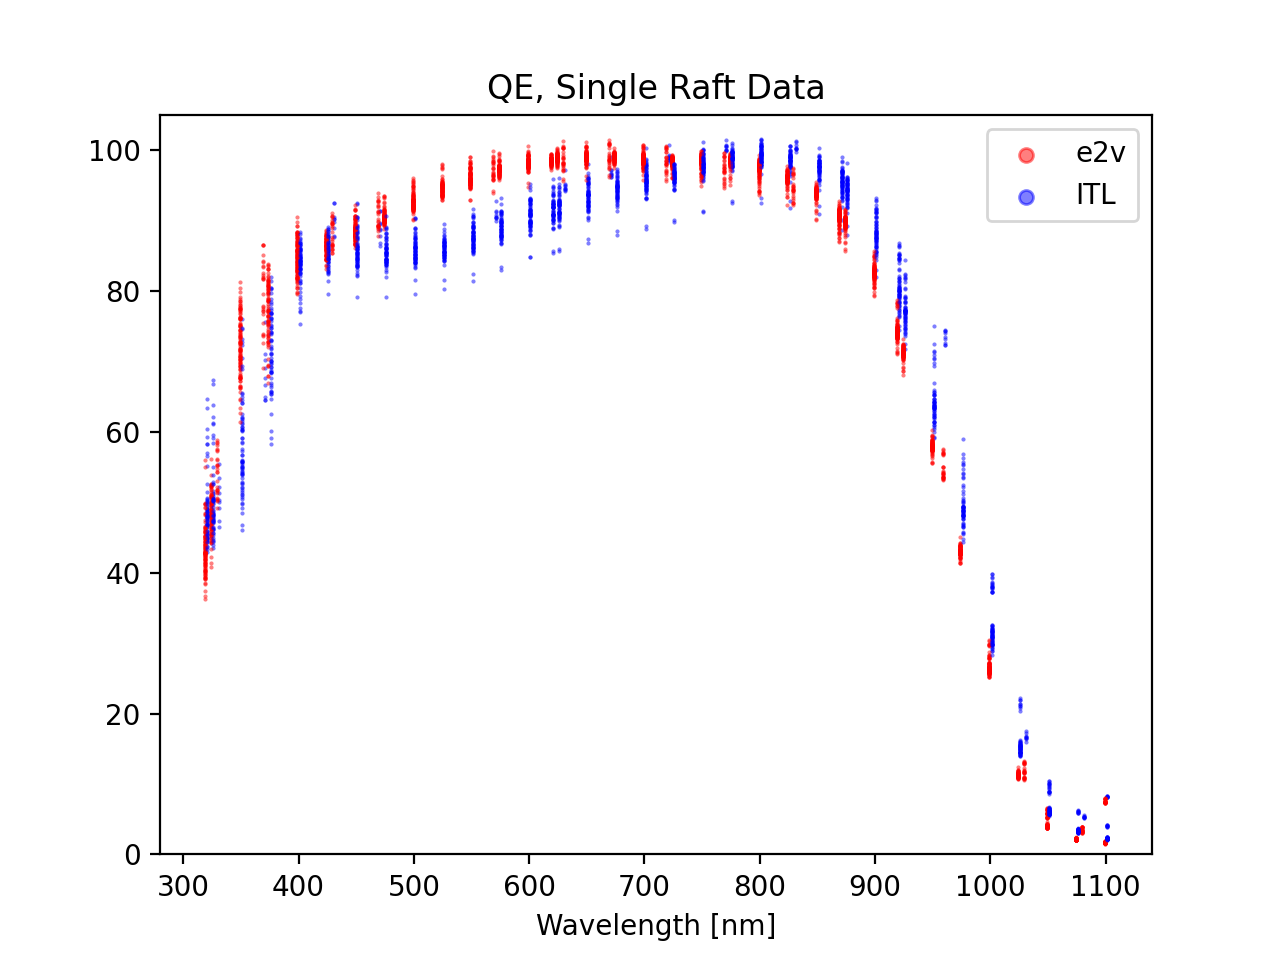

In [17]:
f,ax = plt.subplots(1,1)
itl = (dfall.type=='itl')
e2v = (dfall.type=='e2v')
for i in range(189):
    ptype = det_ptypes[i]
    if ptype=='E2V':
        an_e2v = i
        points_e2v = ax.scatter(dfall['wl'].iloc[i]-1.0,dfall['qe'].iloc[i],marker='.',c='red',s=1.0,alpha=0.5,label='e2v')
    elif ptype=='ITL':
        an_itl = i
        points_itl = ax.scatter(dfall['wl'].iloc[i]+1.0,dfall['qe'].iloc[i],marker='.',c='blue',s=1.0,alpha=0.5,label='ITL')

                
        
ax.set_xlabel('Wavelength [nm]')
ax.set_ylim(0.,105.)
ax.set_title('QE, Single Raft Data')

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[an_e2v],handles[an_itl]], [labels[an_e2v],labels[an_itl]],markerscale=10.)

#ax.legend(markerscale=10.)

# Convert from a Spectrum to CIE colors (from https://scipython.com/blog/converting-a-spectrum-to-a-colour/)

In [18]:
# colour_system.py

def xyz_from_xy(x, y):
    """Return the vector (x, y, 1-x-y)."""
    return np.array((x, y, 1-x-y))

class ColourSystem:
    """A class representing a colour system.

    A colour system defined by the CIE x, y and z=1-x-y coordinates of
    its three primary illuminants and its "white point".

    TODO: Implement gamma correction

    """

    # The CIE colour matching function for 380 - 780 nm in 5 nm intervals
    cmf = np.loadtxt('cie-cmf.txt', usecols=(1,2,3))

    def __init__(self, red, green, blue, white, useden=None, usenorm=None):
        """Initialise the ColourSystem object.

        Pass vectors (ie NumPy arrays of shape (3,)) for each of the
        red, green, blue  chromaticities and the white illuminant
        defining the colour system.

        """

        # Chromaticities
        self.red, self.green, self.blue = red, green, blue
        self.white = white
        # The chromaticity matrix (rgb -> xyz) and its inverse
        self.M = np.vstack((self.red, self.green, self.blue)).T 
        self.MI = np.linalg.inv(self.M)
        # White scaling array
        self.wscale = self.MI.dot(self.white)
        # xyz -> rgb transformation matrix
        self.T = self.MI / self.wscale[:, np.newaxis]
        
        self.useden = useden
        self.usenorm = usenorm
        self.maxden = 0.0
        self.maxnorm = 0.0
        

    def xyz_to_rgb(self, xyz, out_fmt=None):
        """Transform from xyz to rgb representation of colour.

        The output rgb components are normalized on their maximum
        value. If xyz is out the rgb gamut, it is desaturated until it
        comes into gamut.

        By default, fractional rgb components are returned; if
        out_fmt='html', the HTML hex string '#rrggbb' is returned.

        """

        rgb = self.T.dot(xyz)
        if np.any(rgb < 0):
            # We're not in the RGB gamut: approximate by desaturating
            w = - np.min(rgb)
            rgb += w
            
        self.maxnorm = max(np.max(rgb),self.maxnorm)
        if not np.all(rgb==0) and self.usenorm==None:
            # Normalize the rgb vector
            rgb /= np.max(rgb) 
            
        if self.usenorm!=None:
            rgb /= self.usenorm
            
        if out_fmt == 'html':
            return self.rgb_to_hex(rgb)
        return rgb

    def rgb_to_hex(self, rgb):
        """Convert from fractional rgb values to HTML-style hex string."""

        hex_rgb = (255 * rgb).astype(int)
        return '#{:02x}{:02x}{:02x}'.format(*hex_rgb)

    def spec_to_xyz(self, spec):
        """Convert a spectrum to an xyz point.

        The spectrum must be on the same grid of points as the colour-matching
        function, self.cmf: 380-780 nm in 5 nm steps.

        """

        XYZ = np.sum(spec[:, np.newaxis] * self.cmf, axis=0)
        den = np.sum(XYZ) 
        self.maxden = max(den,self.maxden)

        if self.useden != None:
            den = self.useden

        if den == 0.:
            return XYZ
        return XYZ / den

    def spec_to_rgb(self, spec, out_fmt=None):
        """Convert a spectrum to an rgb value."""

        xyz = self.spec_to_xyz(spec)
        return self.xyz_to_rgb(xyz, out_fmt)


In [19]:
illuminant_D65 = xyz_from_xy(0.3127, 0.3291)


cs_srgb = ColourSystem(red=xyz_from_xy(0.64, 0.33),
                       green=xyz_from_xy(0.30, 0.60),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D65)

illuminant_LED_B3 = xyz_from_xy(0.3756,0.3723)
cs_srgb_LED = ColourSystem(red=xyz_from_xy(0.64, 0.33),
                       green=xyz_from_xy(0.30, 0.60),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_LED_B3)


illuminant_D50 = xyz_from_xy(0.3457, 0.3585)
cs_srgb_D50 = ColourSystem(red=xyz_from_xy(0.64, 0.33),
                       green=xyz_from_xy(0.30, 0.60),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D50,useden=None,usenorm=None)

cs_srgb_D50_nonorm = ColourSystem(red=xyz_from_xy(0.64, 0.33),
                       green=xyz_from_xy(0.30, 0.60),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D50,useden=71440.1005625912,usenorm=3.9030950844565306)


In [20]:
# gamma correction, rgb to srgb see https://en.wikipedia.org/wiki/SRGB#The_forward_transformation_(CIE_XYZ_to_sRGB)
def linear_srgb_to_rgb(rgb):
    nonlinearity = np.vectorize(lambda x: 12.92*x if x < 0.0031308 else 1.055*(x**(1.0/2.4))-0.055)
    return nonlinearity(rgb)

# Get RGB for each CCD, using spec_to_rgb

## Use https://apps.automeris.io/wpd/ to scrape

In [21]:
# LED spectra from https://www.aliexpress.us/item/2251801693429821.html?gatewayAdapt=glo2usa4itemAdapt&_randl_shipto=US
LED_5000K = pd.read_csv('Cree-5000K.csv',names=['wl','t'])
LED_5000K = LED_5000K.sort_values('wl')
LED5000Kinterp = sp.interpolate.interp1d(LED_5000K.wl,LED_5000K.t,kind='quadratic',fill_value='extrapolate')

LED_4000K = pd.read_csv('Cree-4000K.csv',names=['wl','t'])
LED_4000K = LED_4000K.sort_values('wl')
LED4000Kinterp = sp.interpolate.interp1d(LED_4000K.wl,LED_4000K.t,kind='quadratic',fill_value='extrapolate')

In [22]:
# LED spectrum from https://www.digikey.com/en/products/detail/SAW8P42A-S0S5-EA/897-1141-2-ND/3767483
LED_neutral = pd.read_csv('LED-neutral-white.csv',names=['wl','t'])
LEDinterp = sp.interpolate.interp1d(LED_neutral.wl,LED_neutral.t,kind='quadratic',fill_value='extrapolate')

In [23]:
import scipy.io
Clean_Room = scipy.io.loadmat('spd-2022-11-09-09-SLAC_RoomLighting.mat')
cr_wl = Clean_Room['wavelength'].T[0]
cr_flux = Clean_Room['data'].T[0]
cr_room_interp = sp.interpolate.interp1d(cr_wl,cr_flux,kind='quadratic',fill_value='extrapolate')

<IPython.core.display.Javascript object>


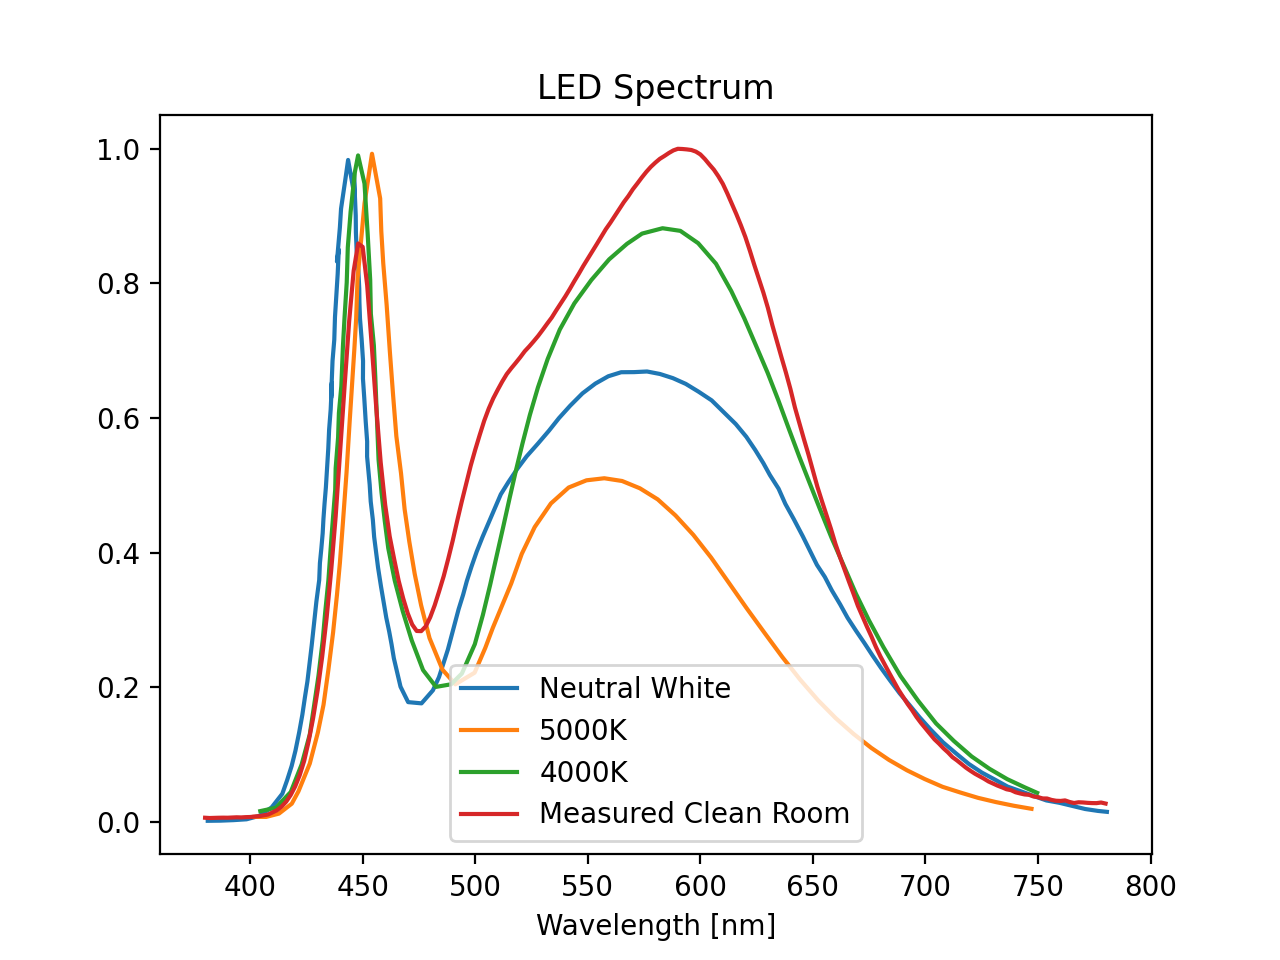

In [24]:
f,ax = plt.subplots(1,1)
h = ax.plot(LED_neutral.wl,LED_neutral.t,label='Neutral White')
h = ax.plot(LED_5000K.wl,LED_5000K.t/100.,label='5000K')
h = ax.plot(LED_4000K.wl,LED_4000K.t/100.,label='4000K')
h = ax.plot(cr_wl,cr_flux/np.max(cr_flux),label='Measured Clean Room')


ax.set_xlabel('Wavelength [nm]')
ax.set_title('LED Spectrum')
ax.legend()

# calculate RGB coefficients for Camera

In [25]:
bays = get_rtms()
slots = get_slots()

ccdsize = 4.0 # in mm

xs = []
ys = []
rs = []
gs = []
bs = []
rgbs = []
srgbs = []

wls = np.arange(380.,780.+5.,step=5)
#LED = LEDinterp(wls)
LED = LED4000Kinterp(wls)
LED_Clean_Room = cr_room_interp(wls)

for bay in bays:
    for slot in slots:
        use = (dfall.bay==bay) & (dfall.slot==slot)
        bayslot = bay+"_"+slot
        idet = det_nums[bayslot]
        
        waves = dfall['wl'].iloc[idet]
        qes = dfall['qe'].iloc[idet]
        qeinterp = sp.interpolate.interp1d(waves,qes, kind='quadratic')

        xbay = int(bay[1:2]) - 2
        ybay = int(bay[2:3]) - 2
        xslot = int(slot[1:2]) - 1
        yslot = int(slot[2:3]) - 1
        
        x = xbay*3*ccdsize + xslot*ccdsize
        y = ybay*3*ccdsize + yslot*ccdsize
        xs.append(x)
        ys.append(y)
                
        reflection = (100.0 - qeinterp(wls))
        refl_t_LED = reflection * LED_Clean_Room  # was just LED
        rgb_col = cs_srgb_LED.spec_to_rgb(refl_t_LED, out_fmt=None)  #was _D50
        rs.append(rgb_col[0])
        gs.append(rgb_col[1])
        bs.append(rgb_col[2])
        rgbs.append(rgb_col)
        
        srgbs.append(linear_srgb_to_rgb(rgb_col))
       
datacol = {'x':xs,'y':ys,'r':rs,'g':gs,'b':bs,'rgb':rgbs,'srgb':srgbs}
dfcol = pd.DataFrame(datacol)

<IPython.core.display.Javascript object>


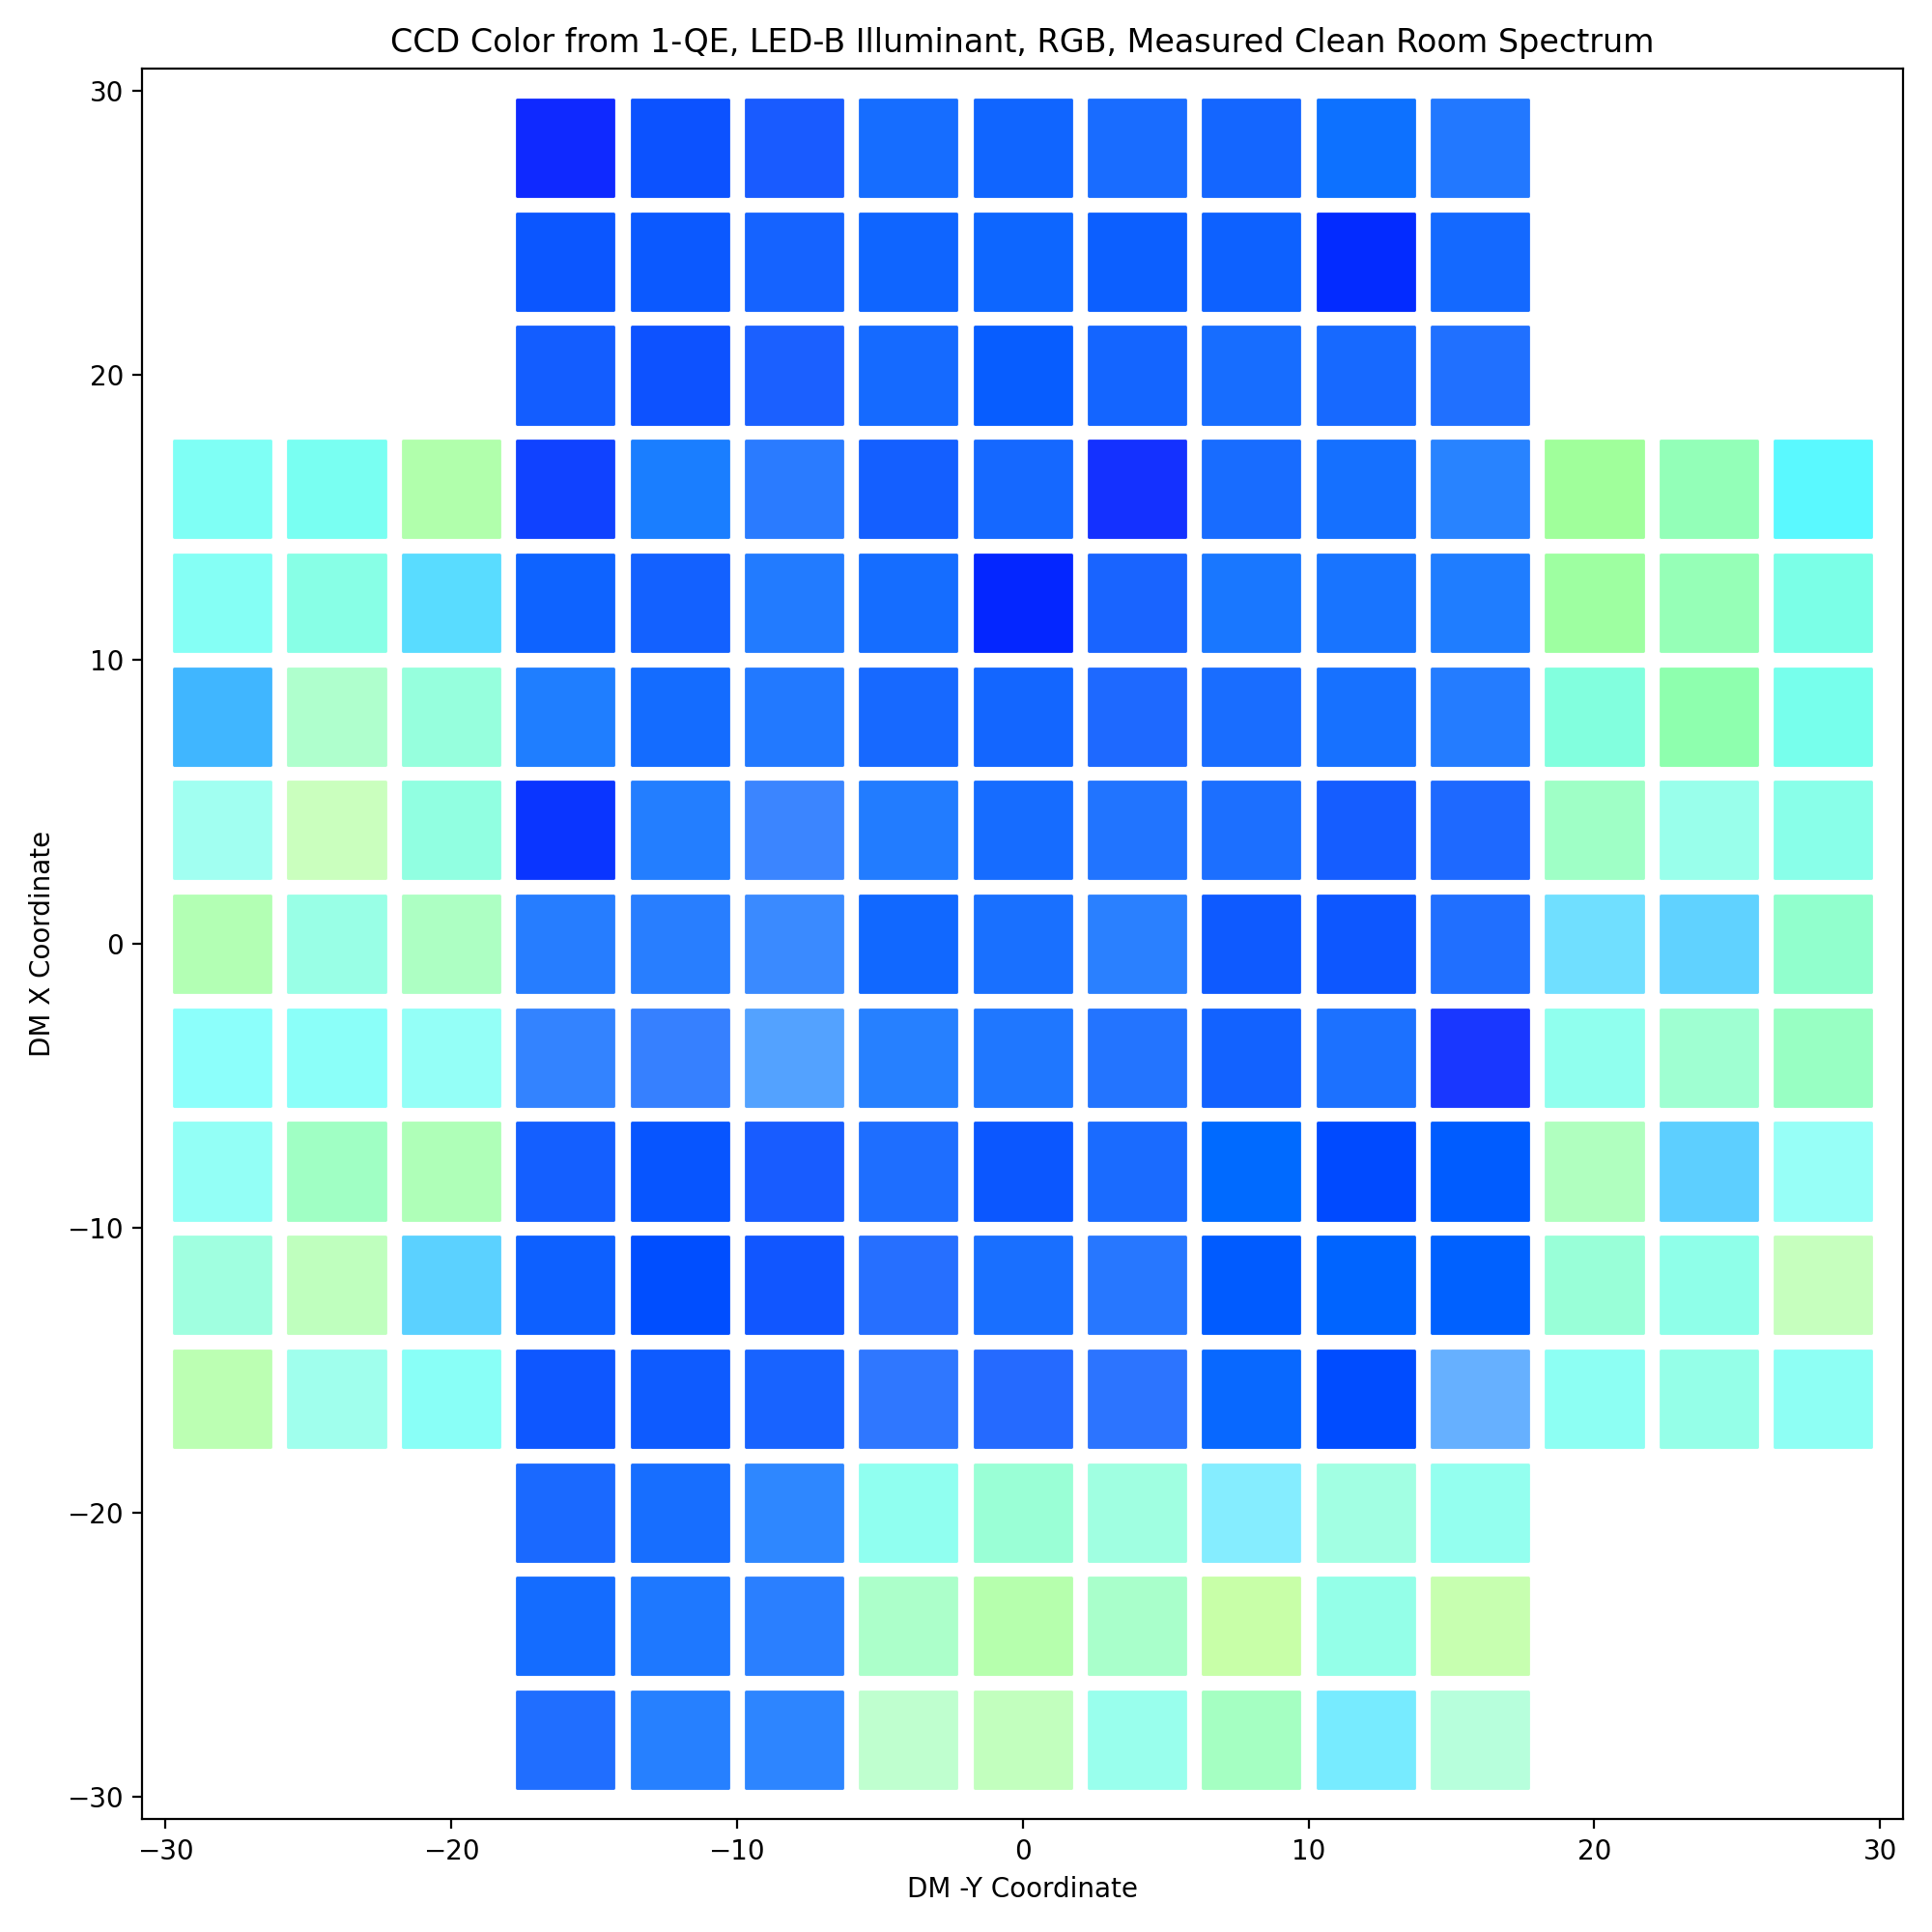

In [30]:
f,ax = plt.subplots(1,1,figsize=(10,10))
h = ax.scatter(-dfcol.x,dfcol.y,c=dfcol.rgb,marker='s',s=1300)
ax.set_xlabel('DM -Y Coordinate')
ax.set_ylabel('DM X Coordinate')
ax.set_title('CCD Color from 1-QE, LED-B Illuminant, RGB, Measured Clean Room Spectrum')
f.tight_layout()

<IPython.core.display.Javascript object>


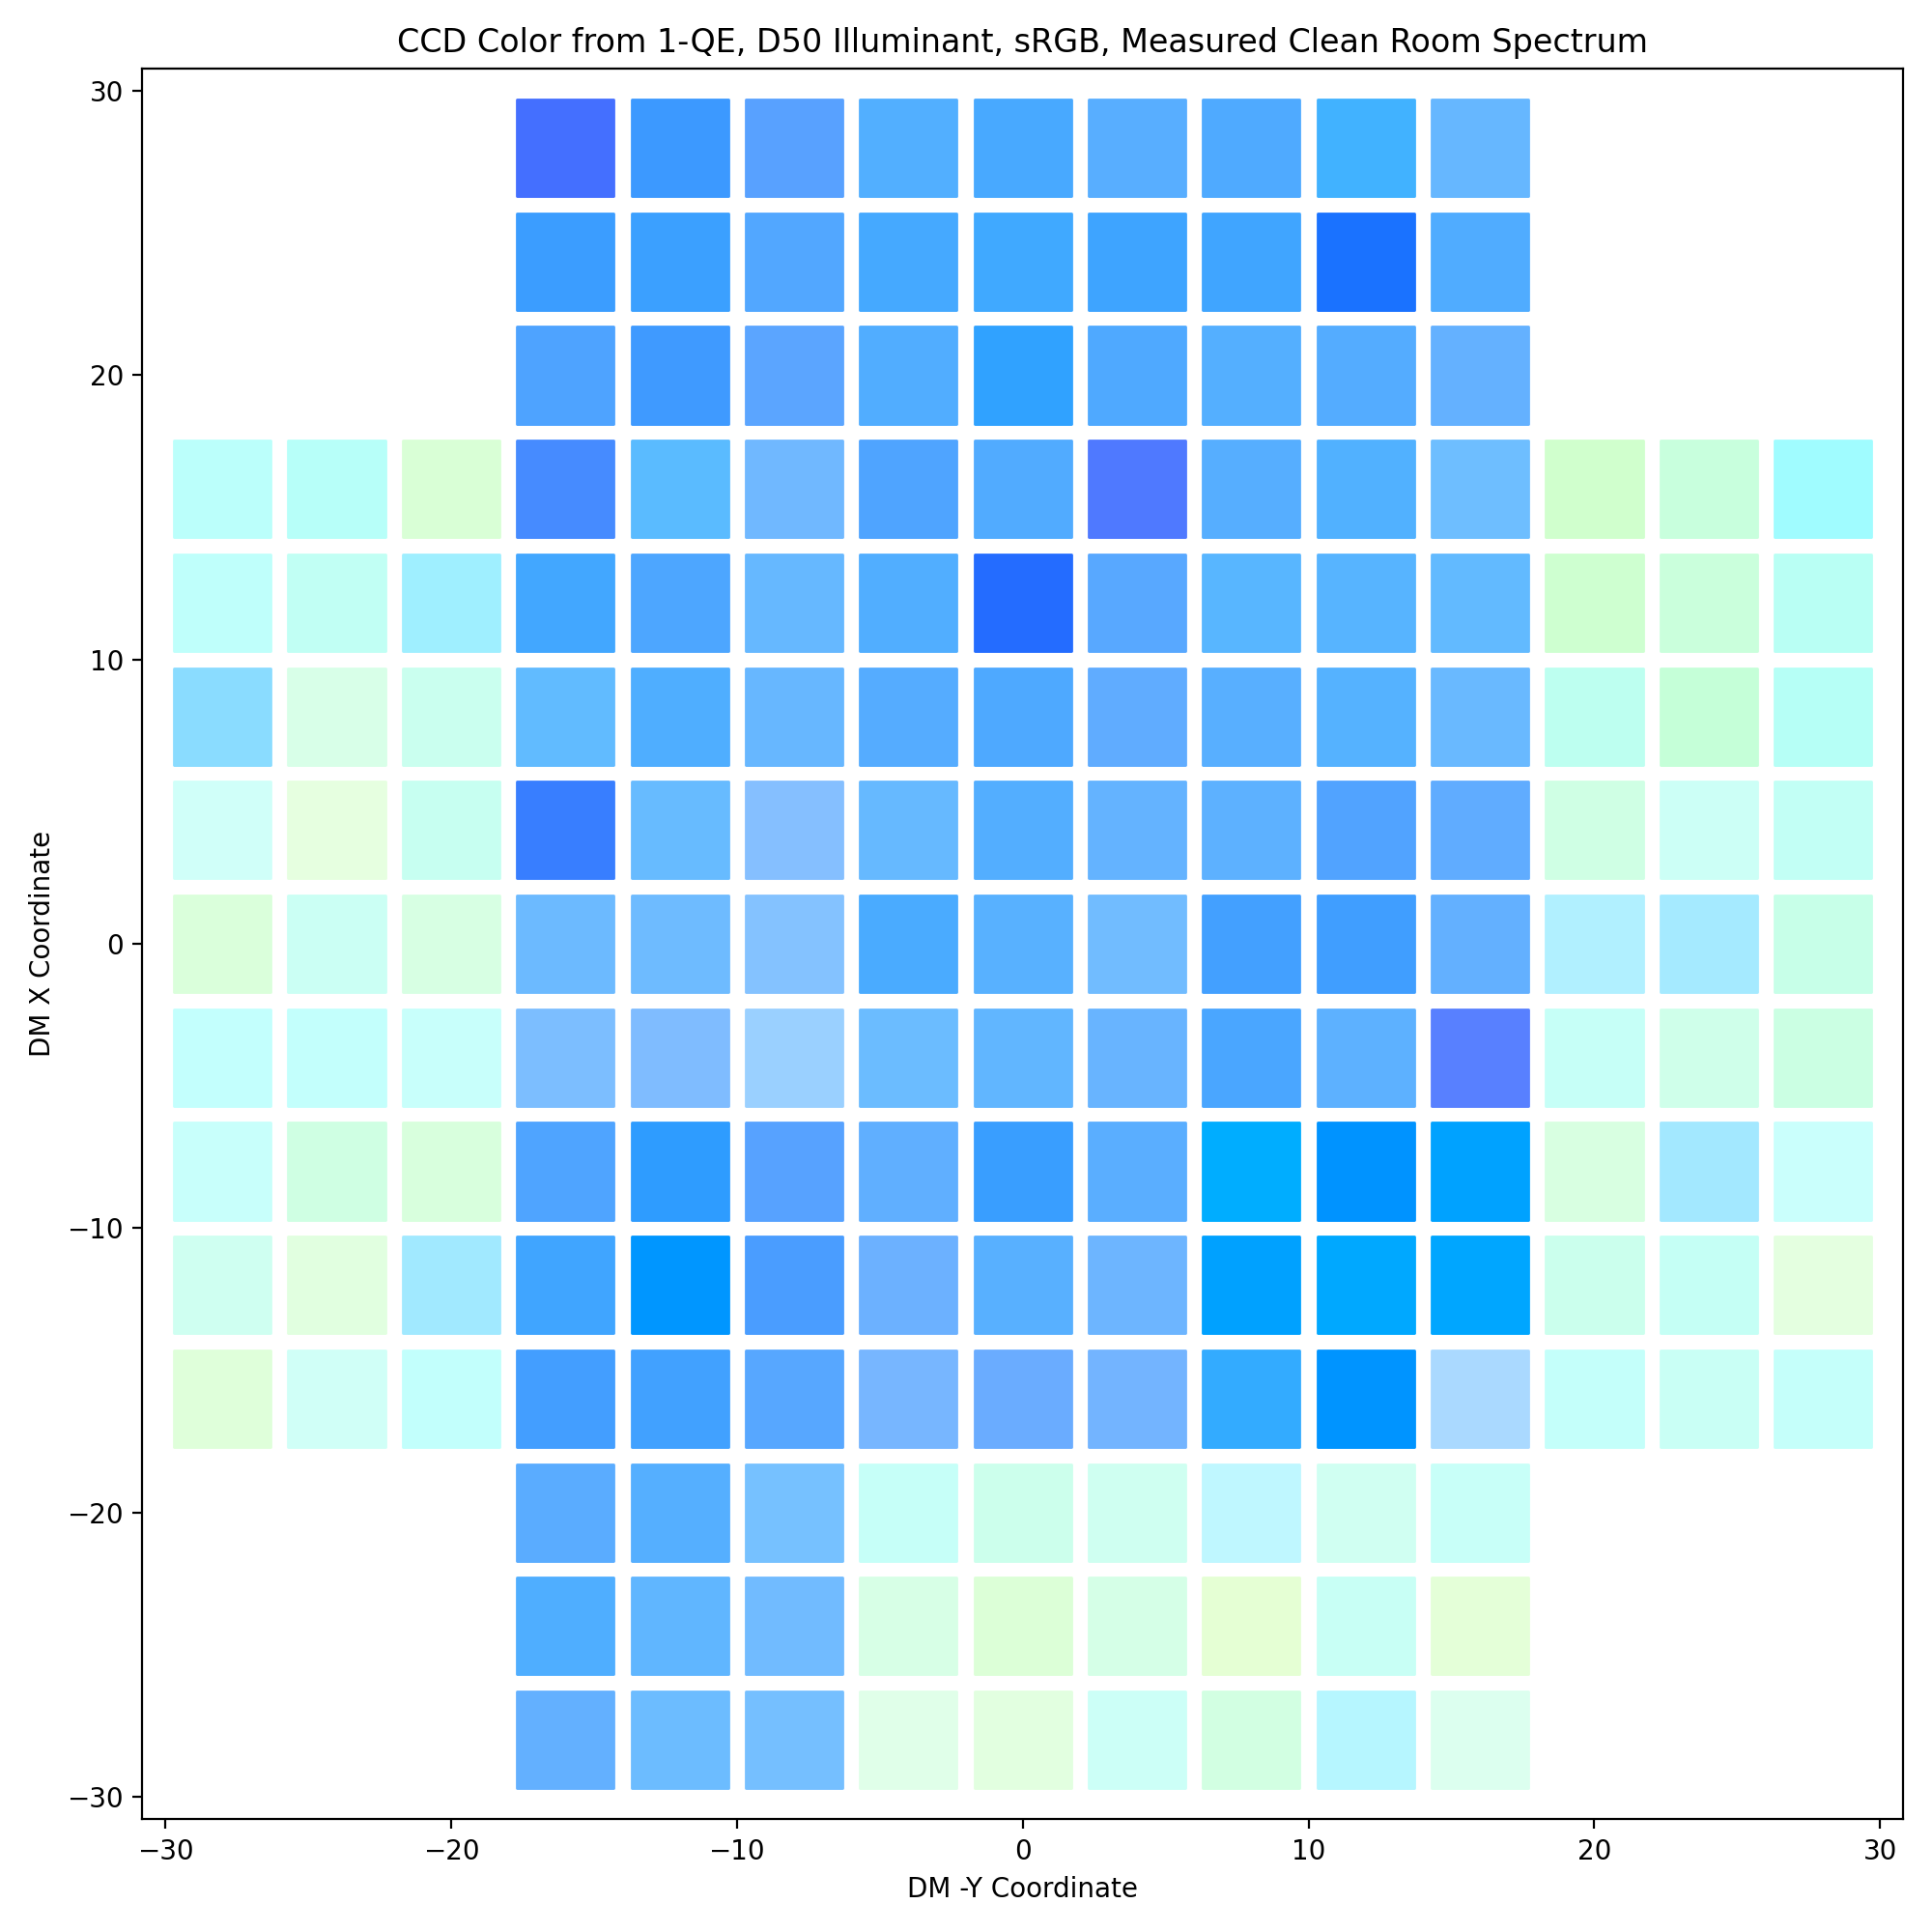

In [27]:
f,ax = plt.subplots(1,1,figsize=(10,10))
h = ax.scatter(-dfcol.x,dfcol.y,c=dfcol.srgb,marker='s',s=1300)
ax.set_xlabel('DM -Y Coordinate')
ax.set_ylabel('DM X Coordinate')
ax.set_title('CCD Color from 1-QE, D50 Illuminant, sRGB, Measured Clean Room Spectrum')
f.tight_layout()

<IPython.core.display.Javascript object>


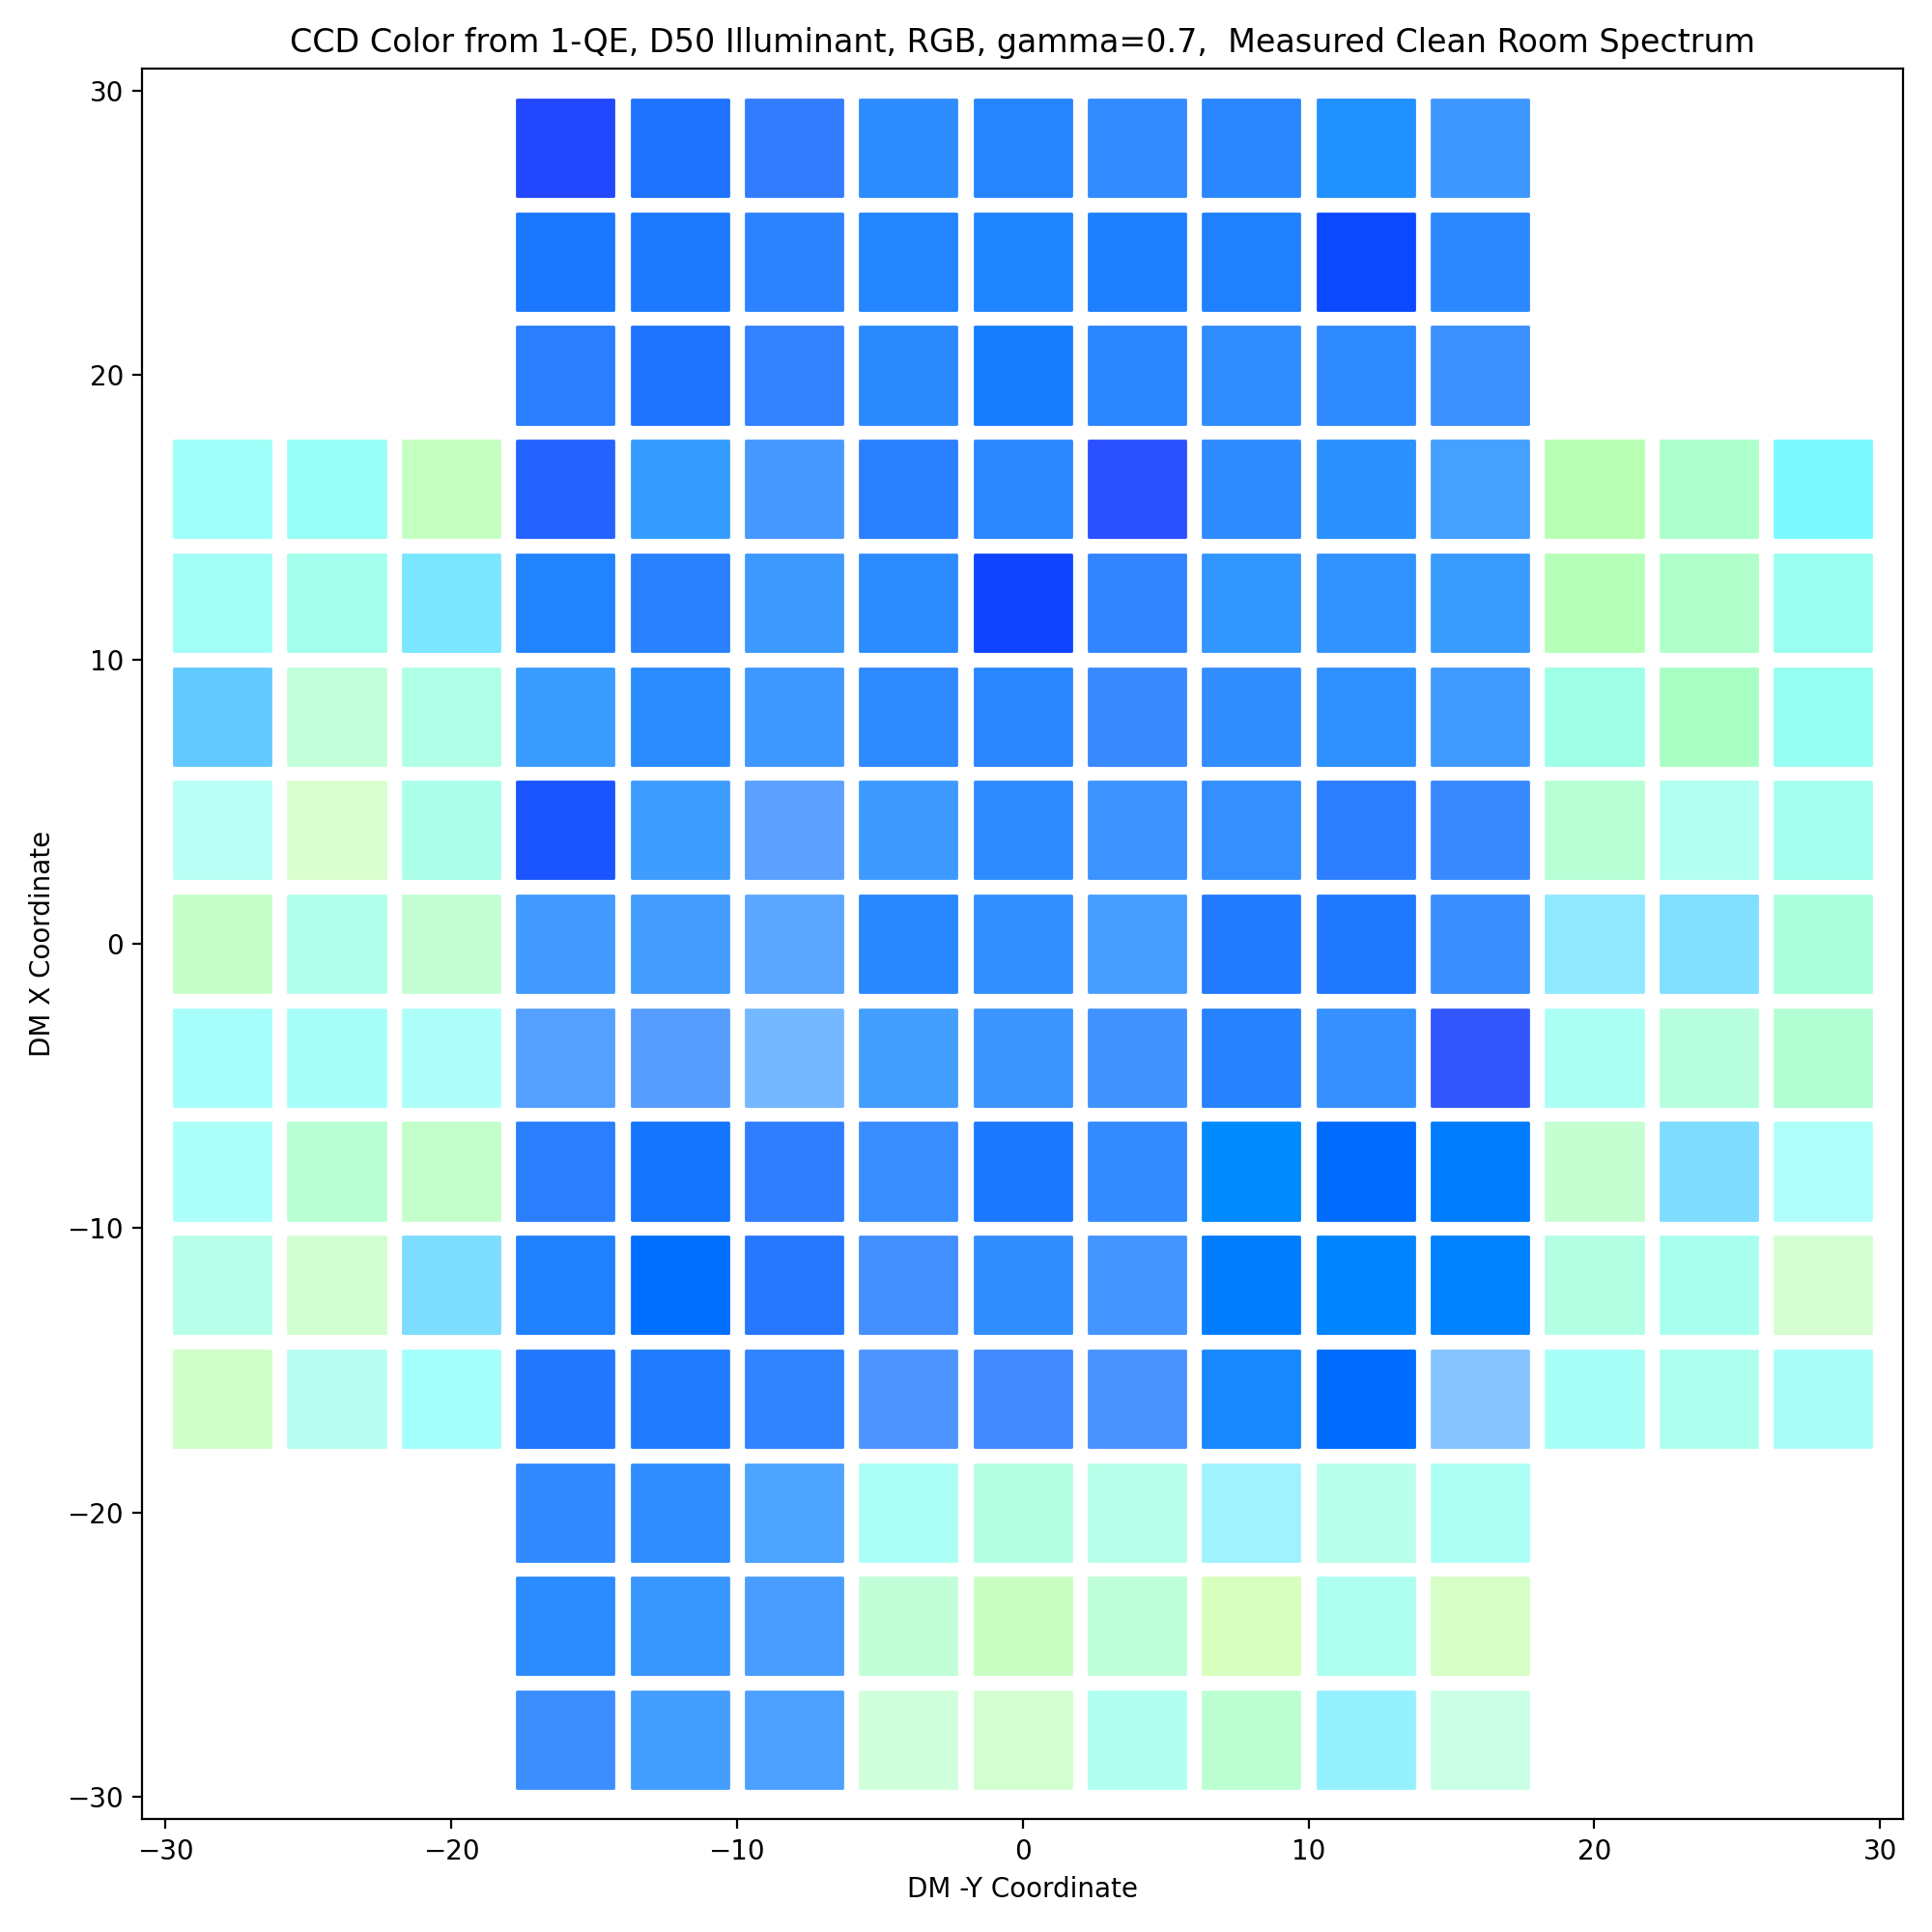

In [28]:
f,ax = plt.subplots(1,1,figsize=(10,10))
h = ax.scatter(-dfcol.x,dfcol.y,c=np.power(dfcol.rgb,0.7),marker='s',s=1300)
ax.set_xlabel('DM -Y Coordinate')
ax.set_ylabel('DM X Coordinate')
ax.set_title('CCD Color from 1-QE, D50 Illuminant, RGB, gamma=0.7,  Measured Clean Room Spectrum')
f.tight_layout()

In [29]:
print(cs_srgb_D50.maxden)
print(cs_srgb_D50.maxnorm)

0.0
0.0


## Wow - looks great!! 

### The e2v that are darker blue are matched in the image, R32_S22, R33_S22, R23_S11 and R23_S02, R14_S11, R12_S00 - although perhaps not seen as much bluer in the images
